In [146]:
# run so that tourism <- original data
import pandas as pd
tourism = pd.read_csv('tourism.csv')
tourism = tourism[tourism['year'] < 2020]

In [147]:
# run so that countries <- list of valid ccountries
# Add continent info
import pycountry_convert as pc
from pycountry import countries

def country_to_continent(code):
    try:
        alpha2 = countries.get(alpha_3=code).alpha_2
        cont_code = pc.country_alpha2_to_continent_code(alpha2)
        return pc.convert_continent_code_to_continent_name(cont_code)
    except:
        return None

tourism['continent'] = tourism['country_code'].apply(country_to_continent)
tourism = tourism.dropna(subset=['continent'])

countries = tourism['country'].unique()

In [148]:
# run so that tourism['population'] gets filled
import wbdata
import pandas as pd

# Define indicator
indicator = {'SP.POP.TOTL': 'population'}

# Fetch data
copy = wbdata.get_dataframe(indicator)

# Reset index
copy = copy.reset_index()
# Filter years
copy['population'] = copy.dropna()['population'].astype(int)
copy['year'] = copy['date'].astype(int)
copy = copy[copy['year'] >= 1999]
copy = copy[copy['year'] <= 2023]

# merge on year and country
tourism = tourism.merge(copy, on=['country', 'year'], how = 'inner')


In [149]:
# run so that tourism['continent'] gets filled
import pycountry_convert as pc
from pycountry import countries

def country_to_continent(code):
    try:
        alpha2 = countries.get(alpha_3=code).alpha_2
        cont_code = pc.country_alpha2_to_continent_code(alpha2)
        return pc.convert_continent_code_to_continent_name(cont_code)
    except:
        return None

tourism['continent'] = tourism['country_code'].apply(country_to_continent)
tourism = tourism.dropna(subset=['continent']).reset_index()

In [144]:
tourism.sort_values(by='gdp', ascending=True)

,index,country,country_code,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment,continent,date,population
621,621,Tuvalu,TUV,2001,NaN,1100.000024,NaN,2799.999952,16.128172,1.396473e+07,NaN,NaN,Oceania,2001,9586.0
195,195,Tuvalu,TUV,1999,NaN,1100.000024,NaN,2200.000048,NaN,1.480050e+07,NaN,NaN,Oceania,1999,9496.0
408,408,Tuvalu,TUV,2000,NaN,1100.000024,NaN,2900.000095,NaN,1.507398e+07,NaN,NaN,Oceania,2000,9544.0
834,834,Tuvalu,TUV,2002,NaN,1299.999952,NaN,2700.000048,21.273144,1.684267e+07,NaN,6.53,Oceania,2002,9623.0
1047,1047,Tuvalu,TUV,2003,NaN,1399.999976,NaN,2599.999905,21.068302,1.945634e+07,NaN,NaN,Oceania,2003,9695.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,4417,"Korea, Dem. People's Rep.",PRK,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia,2019,26037632.0
4436,4436,South Sudan,SSD,2019,NaN,NaN,NaN,NaN,NaN,NaN,87.241364,NaN,Africa,2019,10423384.0
4463,4463,"Venezuela, RB",VEN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South America,2019,28938098.0
4464,4464,British Virgin Islands,VGB,2019,NaN,302399.993896,NaN,NaN,NaN,NaN,NaN,NaN,North America,2019,36395.0


<Axes: >

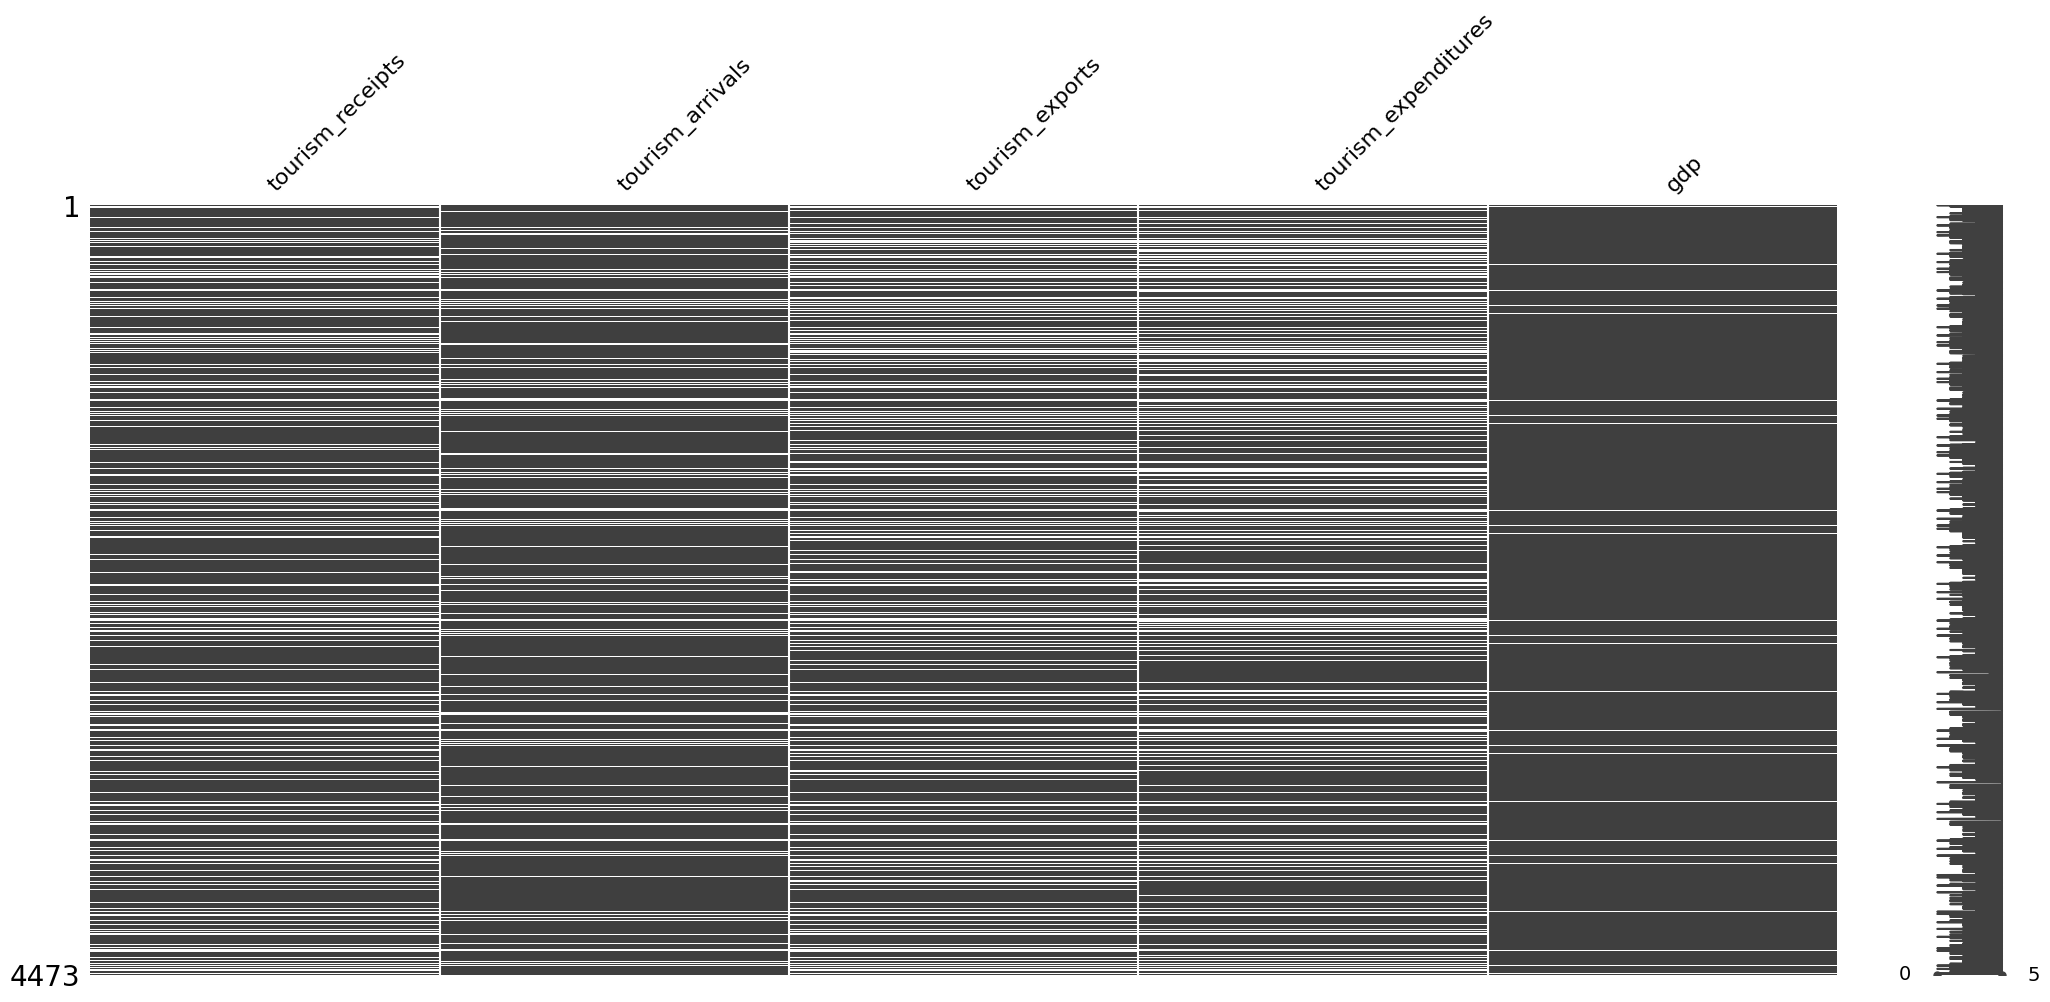

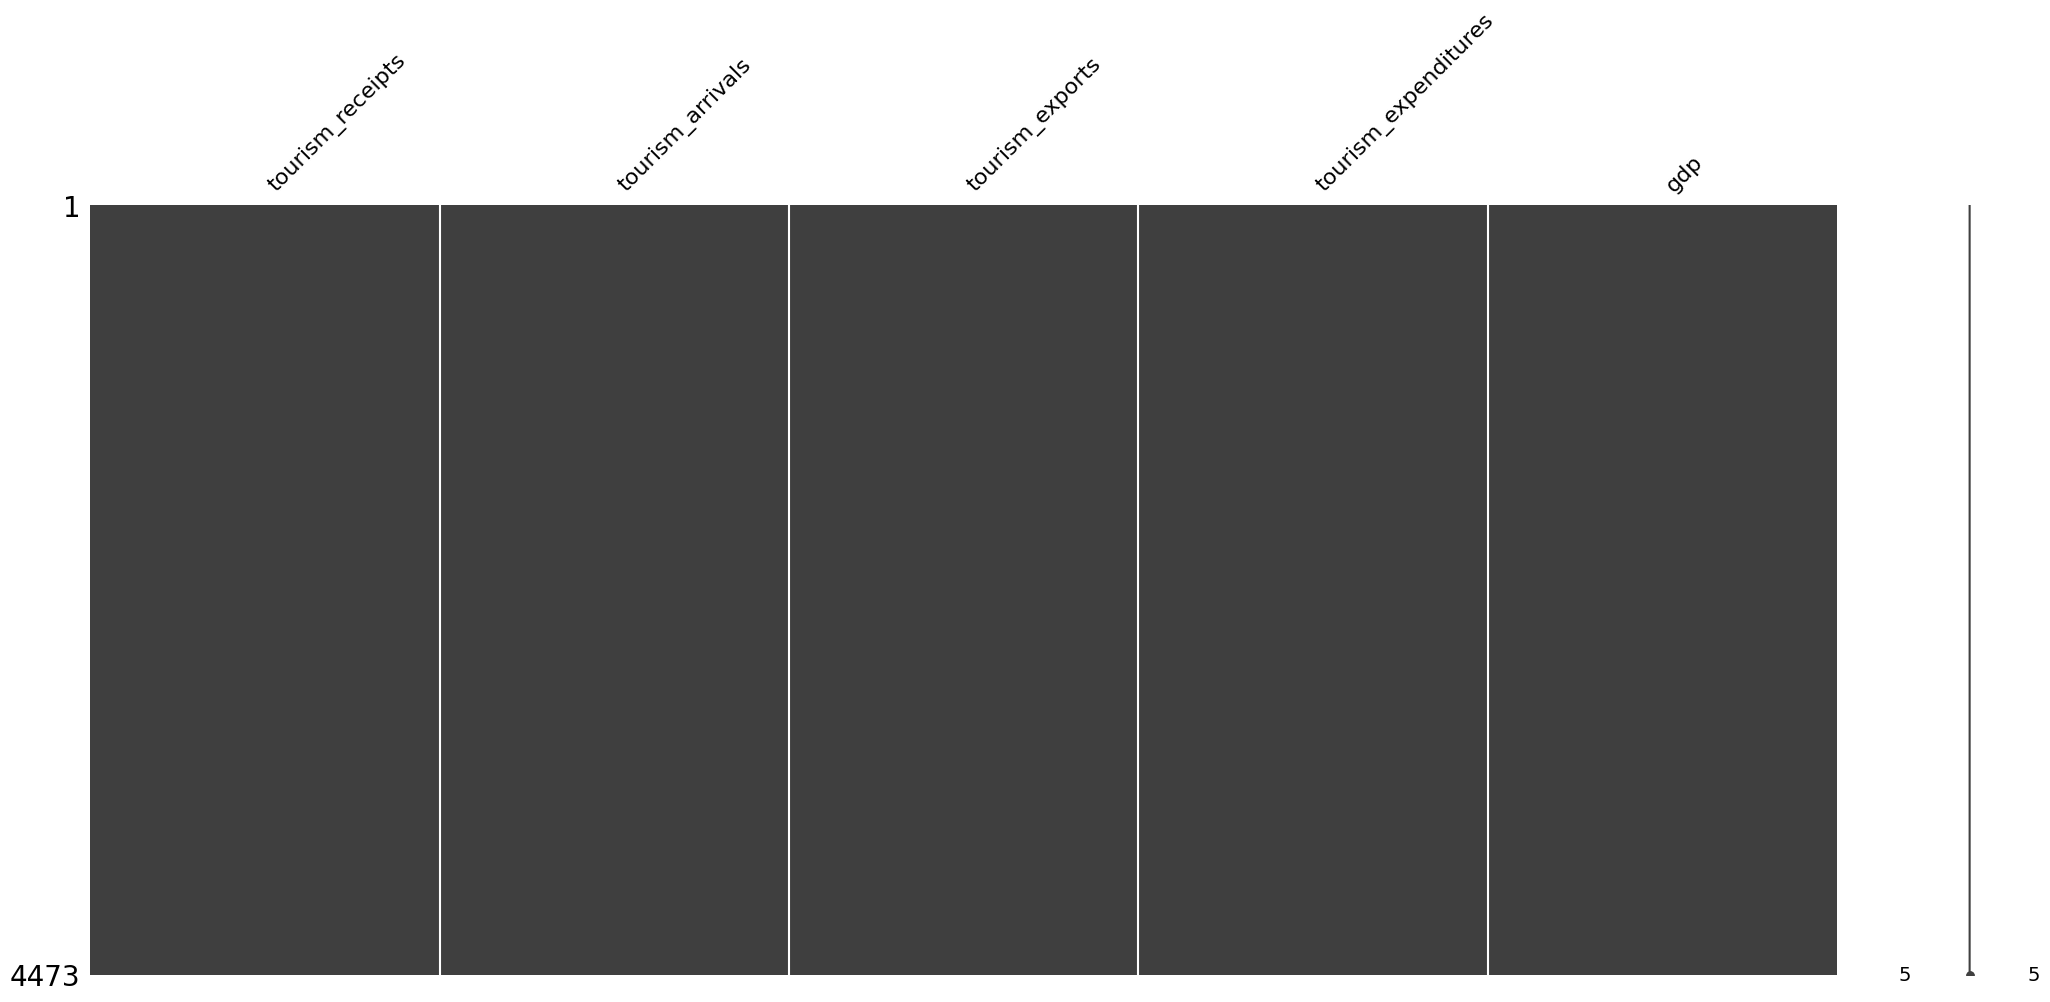

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import miceforest as mf
import missingno as msno
import numpy as np
# Set categories
tourism['country_code'] = tourism['country_code'].astype('category')
tourism['continent'] = tourism['continent'].astype('category')

# Select relevant columns
cols = ['country_code', 'continent', 'year', 'tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_expenditures','gdp', 'population']
tourism = tourism.reset_index(drop=True)


# impute
kernel = mf.ImputationKernel(
    tourism[cols],
    random_state=42
)
kernel.mice(3)

# Get imputed data
completed_df = kernel.complete_data(0)

# Visualize
imputed_cols = ['tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_expenditures', 'gdp']
msno.matrix(tourism[imputed_cols])
msno.matrix(completed_df[imputed_cols])


In [155]:
import pandas as pd
import numpy as np
import miceforest as mf

# test errors with different gdp groups
copy = tourism.copy()
copy = copy[copy['gdp'] < 10**8]
copy = copy[copy['gdp'] > 10**7]
copy = copy.reset_index()

# Step 1: Mask known values (simulate missingness)
cols = ['country_code', 'continent', 'year', 'tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_expenditures','gdp', 'population']
imputed_cols = ['tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_expenditures']

masked_df = copy[cols].copy()
ground_truth = {}

for col in imputed_cols:
    known = masked_df[col].dropna()
    idx = known.sample(frac=0.2, random_state=42).index
    ground_truth[col] = copy.loc[idx, col]  # Store real values
    masked_df.loc[idx, col] = np.nan      # Mask them


for col in masked_df.columns:
    if masked_df[col].dtype == 'object':
        try:
            # Try converting to numeric
            masked_df[col] = pd.to_numeric(masked_df[col])
        except:
            # If it fails, convert to category
            masked_df[col] = masked_df[col].astype('category')


# Step 2: Run MICE
kernel = mf.ImputationKernel(masked_df, random_state=42)
kernel.mice(3)
completed_df = kernel.complete_data(0)

# Step 3: Compare imputed vs real
for col in imputed_cols:
    truth = ground_truth[col]
    imputed = completed_df.loc[truth.index, col]
    errors = imputed - truth
    
    rmse = np.sqrt((errors ** 2).mean())
    mae = errors.abs().mean()

    # Calculate relative errors by dividing errors by the true values' magnitude
    rel_rmse = np.sqrt(((errors / truth) ** 2).mean()) * 100  # % RMSE
    rel_mae = (errors.abs() / truth).mean() * 100            # % MAE

    print(f"{col}:")
    print(f"  RMSE = {rmse:.2f}, MAE = {mae:.2f}")
    print(f"  Relative RMSE = {rel_rmse:.2f}%, Relative MAE = {rel_mae:.2f}%\n")


tourism_receipts:
  RMSE = 722495.68, MAE = 660000.01
  Relative RMSE = 39.70%, Relative MAE = 37.05%

tourism_arrivals:
  RMSE = 46418.49, MAE = 19066.67
  Relative RMSE = 44.88%, Relative MAE = 26.23%

tourism_exports:
  RMSE = 16.11, MAE = 13.31
  Relative RMSE = 36.31%, Relative MAE = 31.33%

tourism_expenditures:
  RMSE = 3.73, MAE = 3.16
  Relative RMSE = 27.85%, Relative MAE = 22.26%



In [5]:
# create groupings of countries by continant
import pycountry_convert as pc

def country_to_continent(country_code):
    try:
        # Convert 3-letter to 2-letter code (if needed)
        from pycountry import countries
        alpha2 = countries.get(alpha_3=country_code).alpha_2
        continent_code = pc.country_alpha2_to_continent_code(alpha2)
        return pc.convert_continent_code_to_continent_name(continent_code)
    except Exception as e:
        return None  # or return 'Unknown'

# Apply to the DataFrame
tourism['continent'] = tourism['country_code'].apply(country_to_continent)
tourism = tourism.dropna(subset=['continent'])
tourism


,country,country_code,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment,continent
0,Aruba,ABW,1999,782000000.0,972000.0,62.542949,NaN,9.495387,1.722905e+09,2.280372,NaN,North America
2,Afghanistan,AFG,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia
4,Angola,AGO,1999,31000000.0,45000.0,0.583858,NaN,2.489638,6.152923e+09,248.195902,NaN,Africa
5,Albania,ALB,1999,218000000.0,371000.0,55.969191,NaN,3.699007,3.212122e+09,0.389438,18.400,Europe
6,Andorra,AND,1999,NaN,9422000.0,NaN,NaN,NaN,1.240295e+09,NaN,NaN,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...
6644,Samoa,WSM,2023,NaN,NaN,NaN,NaN,NaN,9.381894e+08,NaN,NaN,Oceania
6646,"Yemen, Rep.",YEM,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia
6647,South Africa,ZAF,2023,NaN,NaN,NaN,NaN,NaN,3.806993e+11,6.073909,32.098,Africa
6648,Zambia,ZMB,2023,NaN,NaN,NaN,NaN,NaN,2.757796e+10,10.884532,NaN,Africa
